In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Individual Project
## Deliverable 1: Project Proposal
### 1. What is your issue of interest (provide sufficient background information)?
    - auth.log for failed/successful logins as well as authentication processes.
    - var/log/auth.log on Ubuntu and Debian systems
    - contain any information relating to user authorization mechanism (sudo commands)
    - can be used defensively to determine if someone is trying to authenticate who doesn't have permission
    - can be used offensively to figure out who has authorization to the system and their most used avenue of access
    - logs remote logins

### 2. Why is this issue important to you and/or to others?
    - As a network analyst, one of my tasks is to analyze network traffic in order to determine what is happening in 
    the network. We track access vectors and types of traffic as well as parsing through authentication logs and 
    network connections. Surprisingly, my office does not have a data scientist. As such, we waste a lot of time 
    copying and pasting data into spreadsheets instead of using data cleansing, visualization, descriptive statistics, 
    or any other form of analysis that could be vastly helpful. Performing analysis on this data in particular will 
    help me recognize malicious traffic in networks as well as understand what access vectors are taken advantage of. 
    It will also help to identify different types of devices in networks and what they are used for.

### 3. What questions do you have in mind and would like to answer?
    - What IPs try to authenticate?
    - What services are used to authenticate?
    - What IP has the most failed login attempts?
    - what type authentication is the one that fails the most?
    - What IP is trying to be authenticated to?
    - are there any failed/successful remote logins
    - were there any privelege escalation attempts?
        - what commands were run

### 4. Where do you get the data to help answer your questions?
    - http://www.secrepo.com/auth.log/auth.log.gz

### 5. What will be your unit of analysis (for example, patient, organization, or country)? Roughly how many units do you expect to analyze?
    - This auth.log file is pulled from one device with the IP 172.31.27.153. There are approximately 86k lines in the file 
    (might break it down into smaller chunks)

### 6. What variables/measures do you plan to use in your analysis?
    - Data/time
    - Service
    - IP
    - Description
    - will add a username variable based off of descriptions containing usernames

### 7. What kinds of techniques do you you plan to use (for example, summary statistics, scatter plot, bar chart, chi-squared test)?
    - scatter plot - matching date to failed attempts,
    - bar chart - number of logins attempts per user (failure vs success)
    - anything that can show me number of occurances (ie. per username/ip)
    - common generated logs vs abnormal ones
    - I'm sure some kind of statistics once we learn a little more about it

In [38]:
# reads the auth.log file into a dataframe. Is a fixed width format file
df = pd.read_fwf("auth.log", names=["DateTime", "Month", "Date", "Time", "IP", "Service", "Description"])

In [39]:
# shows first 5 lines of the file
df.head()

,DateTime,Month,Date,Time,IP,Service,Description
0,Nov,30,06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,NaN
1,Nov,30,06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,NaN
2,Nov,30,06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,NaN
3,Nov,30,07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],NaN
4,Nov,30,07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],NaN


In [40]:
# converts all data to strings
df = df.astype(str)

- since it is a fixed width format file, the date/time was split into 3 separate columns. I wanted them all in one column so I added the three together and deleted the old ones

In [41]:
# concatenates the data in DateTime, Month, and Date into one column (overwrites DateTime Column)
df["DateTime"] = df["DateTime"] +" "+ df["Month"] + " " + df["Date"]
df.head()

,DateTime,Month,Date,Time,IP,Service,Description
0,Nov 30 06:39:00,30,06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,nan
1,Nov 30 06:47:01,30,06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,nan
2,Nov 30 06:47:03,30,06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,nan
3,Nov 30 07:07:14,30,07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],nan
4,Nov 30 07:07:35,30,07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],nan


In [42]:
# deletes Month column
df.drop('Month', inplace=True, axis=1)

In [43]:
# deletes Date column 
df.drop('Date', inplace=True, axis=1)

In [44]:
df.head()

,DateTime,Time,IP,Service,Description
0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,nan
1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,nan
2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,nan
3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],nan
4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],nan


In [45]:
# Renames the columns and adds a Connecting IP column to fill later
df.columns = ['DateTime', 'IP', 'Service', 'Description', 'Connecting IP']
df.head()

,DateTime,IP,Service,Description,Connecting IP
0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,nan
1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,nan
2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,nan
3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],nan
4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],nan


In [46]:
# Remove leading ip string from IP column (works here because the IP is from the singular host device)
df["IP"]= df["IP"].replace("ip-172-31-27-153", "172.31.27.153")

In [47]:
# Remove string in brackets from Service column 
df["Service"] = df["Service"].str.replace('[\[^0-9\]:]', '', regex=True)

In [48]:
# shows number of rows and columns
df.shape

(86839, 5)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86839 entries, 0 to 86838
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       86839 non-null  object
 1   IP             86839 non-null  object
 2   Service        86839 non-null  object
 3   Description    86839 non-null  object
 4   Connecting IP  86839 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [50]:
df.describe()

,DateTime,IP,Service,Description,Connecting IP
count,86839,86839,86839,86839,86839
unique,54811,1,11,10633,1
top,Dec 29 18:18:32,172.31.27.153,sshd,Received disconnect from 61.197.203.243: 11: B...,nan
freq,18,86839,83638,8996,86839


In [51]:
df.sample(5)

,DateTime,IP,Service,Description,Connecting IP
42270,Dec 10 14:56:18,172.31.27.153,sshd,eceived disconnect from 81.8.0.22: 11: Bye Bye...,nan
71548,Dec 26 02:11:31,172.31.27.153,sshd,Received disconnect from 78.129.223.28: 11: By...,nan
40934,Dec 10 02:32:31,172.31.27.153,sshd,eceived disconnect from 87.106.242.123: 11: By...,nan
47100,Dec 11 22:14:51,172.31.27.153,sshd,reverse mapping checking getaddrinfo for vps.a...,nan
83565,Dec 29 20:08:16,172.31.27.153,sshd,nvalid user mike from 108.63.28.45,nan


In [52]:
# If Description column contains the regex pattern for IP addresses, create neew column with the IP
df["Connecting IP"] = df["Description"].str.extract(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})')

In [53]:
df.head()

,DateTime,IP,Service,Description,Connecting IP
0,Nov 30 06:39:00,172.31.27.153,CRON,pam_unix(cron:session): session closed for use...,NaN
1,Nov 30 06:47:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
2,Nov 30 06:47:03,172.31.27.153,CRON,pam_unix(cron:session): session closed for use...,NaN
3,Nov 30 07:07:14,172.31.27.153,sshd,Connection closed by 122.225.103.87 [preauth],122.225.103.87
4,Nov 30 07:07:35,172.31.27.153,sshd,Connection closed by 122.225.103.87 [preauth],122.225.103.87


In [54]:
# Creates new dataframe of unique IPs from Connecting IP column
uniqueIP = pd.DataFrame(df['Connecting IP'].unique().tolist())
uniqueIP.head(5)

,0
0,NaN
1,122.225.103.87
2,187.12.249.74
3,196.200.90.236
4,1.93.26.70


In [55]:
# Since I only want the first 4 charachters of each service, going to slice out the extras. 
df['Service'] = df['Service'].str.slice(stop=4)

In [56]:
# Create list of unique services. Not sure where the extra letters came from. 
# Doesn't do this in Colab and they aren't in the data file
unique_service = pd.DataFrame(df['Service'].unique().tolist())
unique_service

,0
0,CRON
1,sshd


In [57]:
# Creates new dataframe with a column that counts the total number of occurances of that IP
connecting_IP = pd.DataFrame(df['Connecting IP'].value_counts().reset_index().values, columns=["IP", "Count"])
connecting_IP.head()

,IP,Count
0,61.197.203.243,11261
1,220.99.93.50,10752
2,218.25.17.234,5616
3,188.87.35.25,2013
4,67.205.20.23,1804


In [58]:
# Shows number of unique IPs
df['Connecting IP'].nunique()

1906

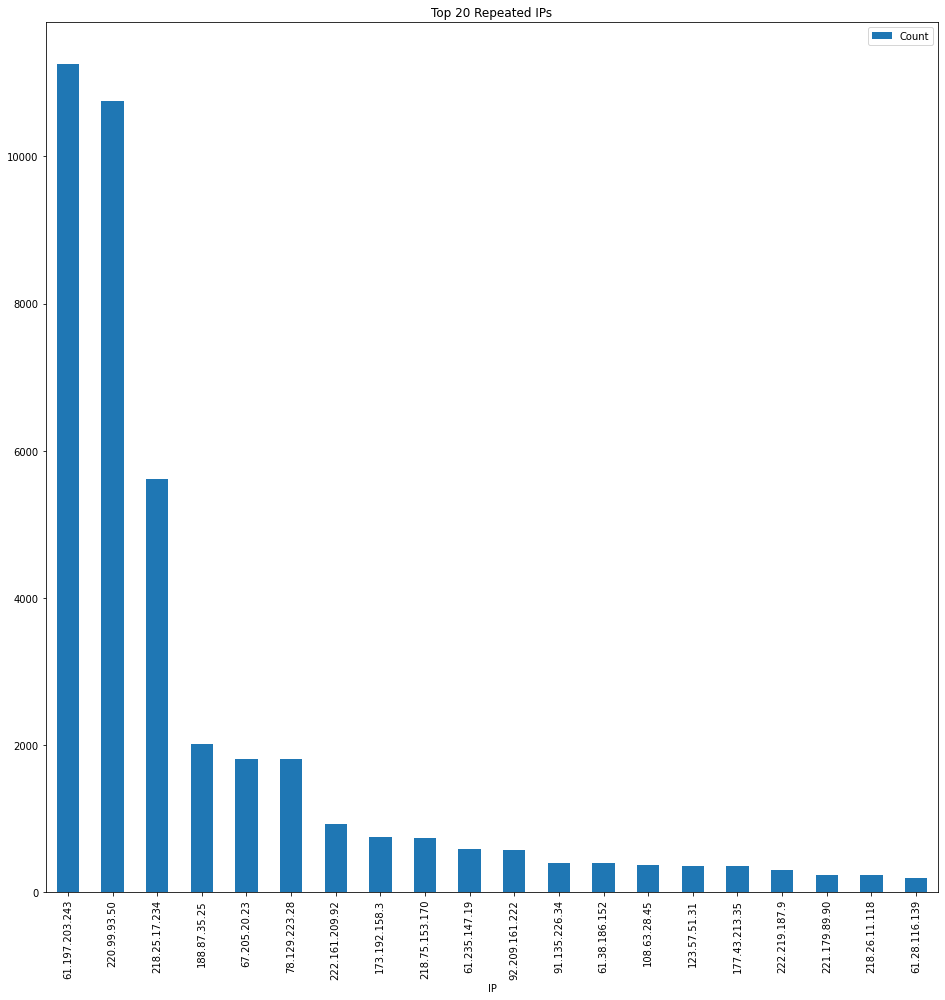

In [59]:
# creates bar chart of the top 20 repeated IPs
connecting_IP.iloc[0:20].plot(kind='bar', title='Top 20 Repeated IPs', x='IP', y='Count', figsize=(16,16))  
plt.show()

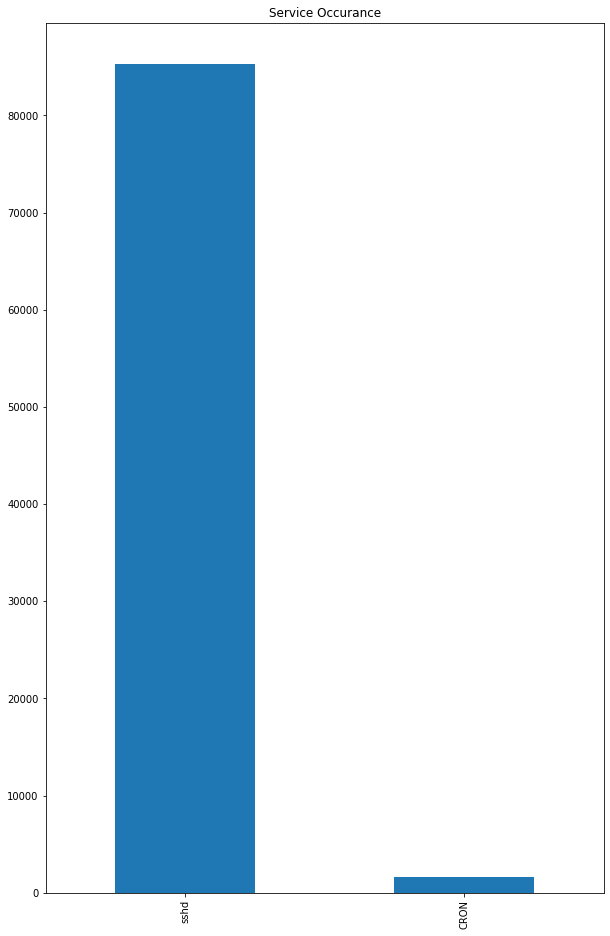

In [60]:
# Graph of the services used and how frequently (couldn't figure out how to get axis labels).
# only showed the first two bars when done in Google Colab. I haven't figured out where the extra came from in this one
df['Service'].value_counts().plot(kind='bar', title='Service Occurance', figsize=(10,16))  
plt.show()

In [61]:
# creates new dataframe of rows that contianed invalid user login attempts
df_invalid_user = df[df["Description"].str.contains(r'Invalid(?!$)')]

In [62]:
df_invalid_user.head()

,DateTime,IP,Service,Description,Connecting IP
10,Nov 30 08:42:04,172.31.27.153,sshd,Invalid user admin from 187.12.249.74,187.12.249.74
23,Nov 30 10:58:27,172.31.27.153,sshd,Invalid user admin from 122.225.109.208,122.225.109.208
342,Nov 30 15:22:39,172.31.27.153,sshd,Invalid user admin from 124.205.250.51,124.205.250.51
345,Nov 30 15:22:43,172.31.27.153,sshd,Invalid user guest from 124.205.250.51,124.205.250.51
348,Nov 30 15:22:48,172.31.27.153,sshd,Invalid user support from 124.205.250.51,124.205.250.51


In [63]:
# finds number of unique user login attempts and counts how many times each occurred
df_invalid_user_count = pd.DataFrame(df_invalid_user['Description'].value_counts().reset_index().values, columns=["Description", "Count"])


In [64]:
df_invalid_user_count

,Description,Count
0,Invalid user test from 188.87.35.25,96
1,Invalid user test from 67.205.20.23,86
2,Invalid user test from 78.129.223.28,86
3,Invalid user test from 220.99.93.50,82
4,Invalid user nagios from 188.87.35.25,65
...,...,...
3882,Invalid user xbian from 92.51.247.73,1
3883,Invalid user xbian from 203.183.230.169,1
3884,Invalid user Admin from 92.54.126.170,1
3885,Invalid user nano from 58.249.115.30,1


In [65]:
# converts Count column to integer
df_invalid_user_count['Count'].astype(int)

0       96
1       86
2       86
3       82
4       65
        ..
3882     1
3883     1
3884     1
3885     1
3886     1
Name: Count, Length: 3887, dtype: int64

In [66]:
# For sake of space, I only want unique logins with over 30 attempts
df_invalid_over_30 = df_invalid_user_count[(df_invalid_user_count['Count'] > 30)]
df_invalid_over_30

,Description,Count
0,Invalid user test from 188.87.35.25,96
1,Invalid user test from 67.205.20.23,86
2,Invalid user test from 78.129.223.28,86
3,Invalid user test from 220.99.93.50,82
4,Invalid user nagios from 188.87.35.25,65
5,Invalid user nagios from 220.99.93.50,65
6,Invalid user zabbix from 188.87.35.25,46
7,Invalid user guest from 188.87.35.25,45
8,Invalid user guest from 220.99.93.50,45
9,Invalid user admin from 222.161.209.92,40


In [67]:
# separates the IP from the description into its own column for clarity
df_invalid_over_30['IP'] = df_invalid_over_30["Description"].str.extract(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})')
df_invalid_over_30

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Description,Count,IP
0,Invalid user test from 188.87.35.25,96,188.87.35.25
1,Invalid user test from 67.205.20.23,86,67.205.20.23
2,Invalid user test from 78.129.223.28,86,78.129.223.28
3,Invalid user test from 220.99.93.50,82,220.99.93.50
4,Invalid user nagios from 188.87.35.25,65,188.87.35.25
5,Invalid user nagios from 220.99.93.50,65,220.99.93.50
6,Invalid user zabbix from 188.87.35.25,46,188.87.35.25
7,Invalid user guest from 188.87.35.25,45,188.87.35.25
8,Invalid user guest from 220.99.93.50,45,220.99.93.50
9,Invalid user admin from 222.161.209.92,40,222.161.209.92


In [68]:
# Removes the invalud use part of the description leaving just the username and IP
df_invalid_over_30['Description'] = df_invalid_over_30['Description'].map(lambda x: str(x)[13:])
df_invalid_over_30

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Description,Count,IP
0,test from 188.87.35.25,96,188.87.35.25
1,test from 67.205.20.23,86,67.205.20.23
2,test from 78.129.223.28,86,78.129.223.28
3,test from 220.99.93.50,82,220.99.93.50
4,nagios from 188.87.35.25,65,188.87.35.25
5,nagios from 220.99.93.50,65,220.99.93.50
6,zabbix from 188.87.35.25,46,188.87.35.25
7,guest from 188.87.35.25,45,188.87.35.25
8,guest from 220.99.93.50,45,220.99.93.50
9,admin from 222.161.209.92,40,222.161.209.92


In [71]:
# removes the IP from the Description column leaving just hte username
df_invalid_over_30['Description'] = df_invalid_over_30['Description'].map(lambda x: str(x)[:-18])
df_invalid_over_30

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Description,Count,IP
0,test,96,188.87.35.25
1,test,86,67.205.20.23
2,test,86,78.129.223.28
3,test,82,220.99.93.50
4,nagios,65,188.87.35.25
5,nagios,65,220.99.93.50
6,zabbix,46,188.87.35.25
7,guest,45,188.87.35.25
8,guest,45,220.99.93.50
9,admin f,40,222.161.209.92


/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


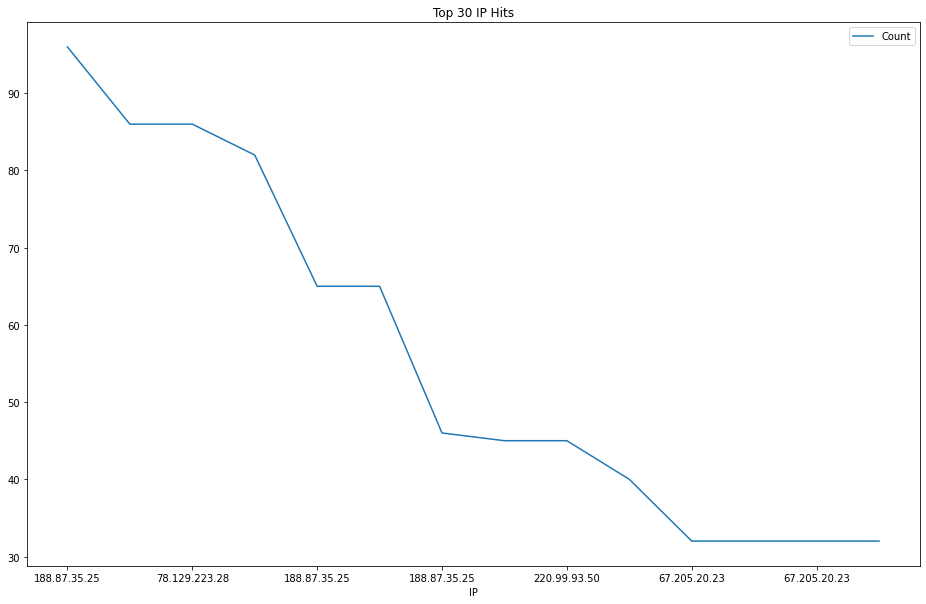

In [70]:
# shows the lnumber of login attempts for each IP with failed attempts over 30
df_invalid_over_30.plot(kind='line',x='IP',y='Count', title='Top 30 IP Hits', figsize=(16,10))
plt.show()

# Conclusion

### Questions Answered
#### What IPs try to authenticate?
    - I focused on the authentication attempts that failed, since those are the ones most likely to be malicious. 
    - There were 1906 unique IPs that attemted to authenticate to the 172.31.27.153 device. There were 3887 failed authentications
#### What services are used to authenticate?
    - CRON and SSHD were the two services used to authenticate. 
#### What IP has the most failed login attempts?
    - 61.197.203.243 had the most login attempts with 11261
    - The IP 188.87.35.25 had the most failed logins with 96 using the username test
#### What type authentication is the one that fails the most?
    - SSHD (secure remote) authentication failed the most frequently 
#### What IP is trying to be authenticated to?
    - The device being authenticated to is 172.31.27.153
#### Are there any failed/successful remote logins?
    - There were 3887 failed login attempts. 
    - Unknown successful
#### Were there any privelege escalation attempts?
    - No. There was no evidence of the sudo command being run in the logs. 
